In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [6]:
df = pd.read_csv('data/enem_scores.csv')
df.sort_values(by='avg_score', ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


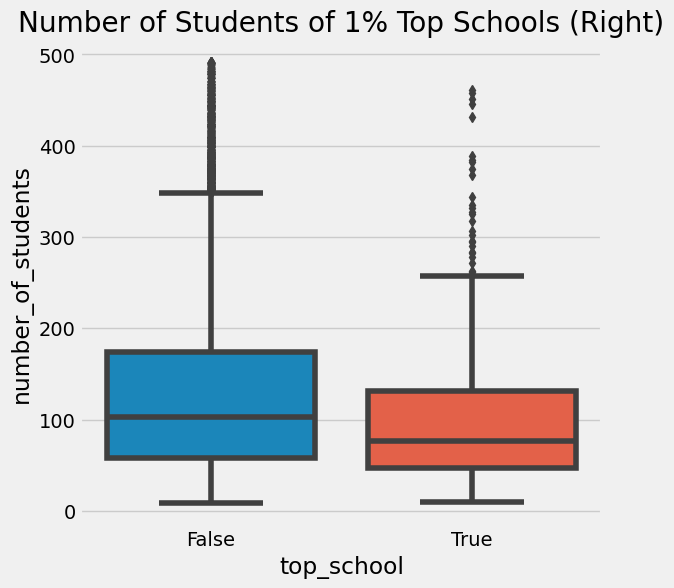

In [15]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

- From the boxplot above, we can tell that at the top 1% of school, they have, on average, fewer students.

## Does smaller school lead to higher academic performance?
- Let's take a look at the bottom 1% of schools

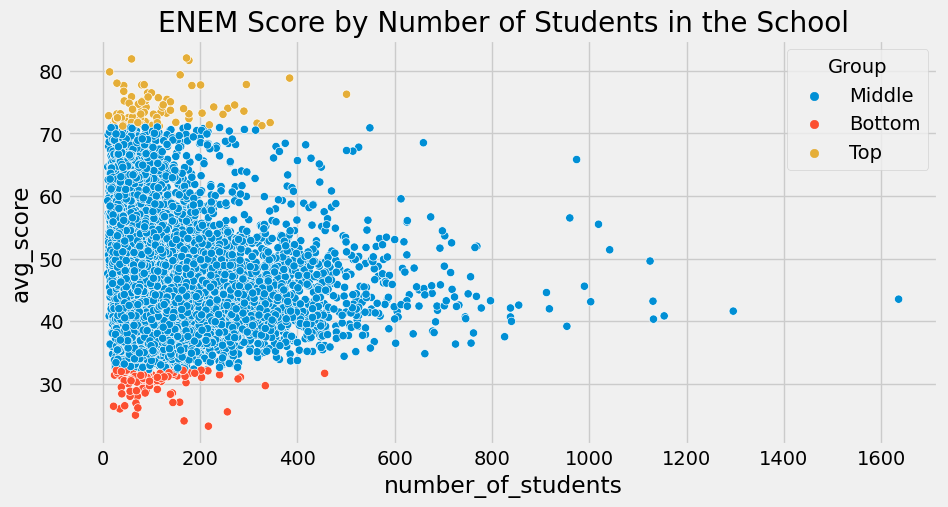

In [20]:
q_99 = np.quantile(df['avg_score'], .99)
q_01 = np.quantile(df['avg_score'], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d : np.select([d['avg_score'] > q_99, d['avg_score'] < q_01],
                                                  ['Top', 'Bottom'], 'Middle')))

plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

- Schools with very few sampels can have very high and low scores simply due to chance
- This graph above shows how the estimates of the school performance have a huge variance when the sample sizes are small.
    - This also indicates that variance shrinks as the sample size increases

# The Standard Error of Our Estimates

In [28]:
data = pd.read_csv('data/online_classroom.csv')
online = data.query('format_ol==1')['falsexam']
face_to_face = data.query('format_ol==0 & format_blended==0')['falsexam']

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print('SE for Online:', se(online))
print('SE for Face to Face', se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face 0.8723511456319104


# Confidence Intervals

- Suppose we have a true abstract distribution of student's test scores with a true mean of 74 and a true standard devaition of 2
- Run 10,000 experiments and on each one, we collect 500 samples

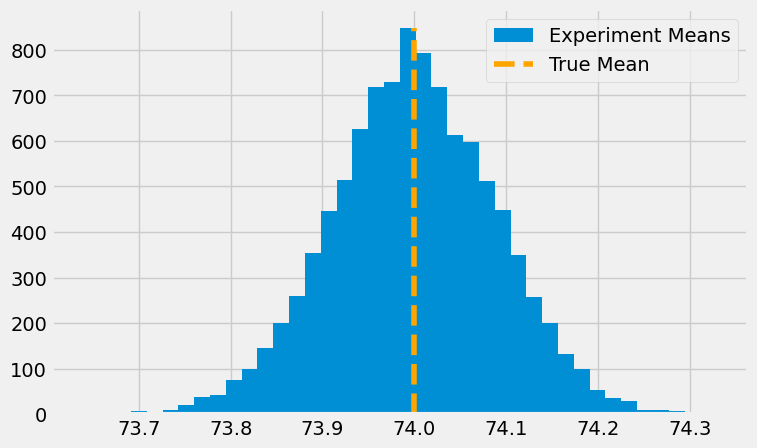

In [37]:
true_std = 2
true_mean = 74

n = 500
def run_experiment():
    return np.random.normal(true_mean, true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

- With the standard error, we can create an interval that will contain the true mean 95% of the time
- According the Central Limit Theorem, means of experiments are normally distributed
- From statistical theory, we know that 95% of the mass of a normal distribution is between 2 standard deviation above and below the mean

In [45]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


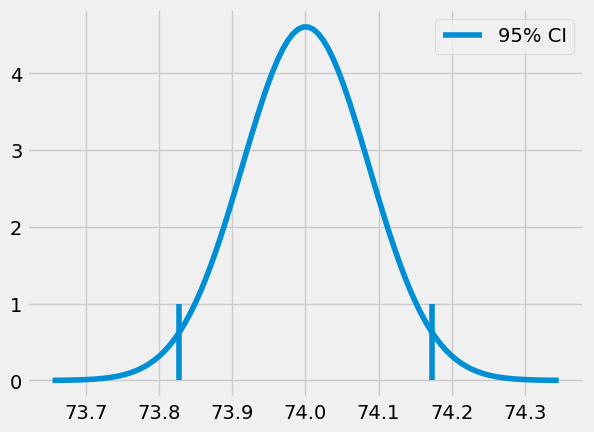

In [46]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

In [62]:
from scipy import stats
z = stats.norm.ppf(.995)  # 0.5% of the mass falls above this value 
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

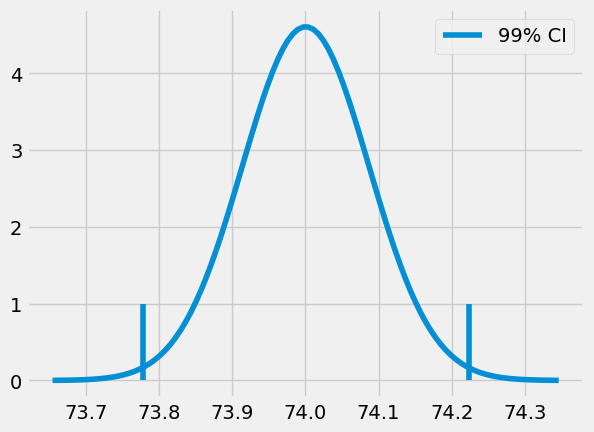

In [63]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

#### Back to classroom experiment, we can construct the confidence interval for the mean exam score for both the online and face to face students' group

In [64]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


- We can see that the 95% CI of the groups doesn't overlap
- This is evidence that our result is not by chance and that the true mean for students in face-to-face classes is higher than the true mean for students in online classes
    - In other words, there is a significant causal decrease in academic performance when switching from face-to-face to online classes

# Hypothesis Testing